In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import random
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

In [6]:
print(torch.__version__)  
print(torch.version.cuda)  

2.5.1+cu121
12.1


In [7]:
print(torch.__version__)  
print(torch.version.cuda)  

2.5.1+cu121
12.1


In [8]:
!nvidia-smi

Wed Feb 12 00:58:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.16                 Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8              5W /   50W |    3815MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
dataset = datasets.ImageFolder("thermal", transform=transform)

class_counts = Counter([label for _, label in dataset.samples])
max_count = max(class_counts.values())  

print(class_counts)  


Counter({0: 220, 3: 142, 2: 93, 5: 80, 1: 67, 4: 34})


In [17]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size 

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [18]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

In [21]:
def train_inception(train_loader, val_loader, num_classes=6, num_epochs=20, lr=0.0001):
    if not torch.cuda.is_available():
        raise RuntimeError("GPU not available. This code requires a GPU to run.")
    device = torch.device("cuda")
    print(f"\nUsing device: {device} ({torch.cuda.get_device_name(device)})\n")

    model = models.inception_v3(weights="DEFAULT")

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    if model.AuxLogits:
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print(f"\nTraining Inception v3 for {num_epochs} epochs...\n")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, aux_outputs = model(images)
            
            loss = criterion(outputs, labels)
            if model.AuxLogits:
                loss_aux = criterion(aux_outputs, labels)
                loss += 0.4 * loss_aux  
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            progress_bar.set_postfix(loss=running_loss / len(train_loader), accuracy=100 * correct / total)
        
        print(f"Epoch {epoch+1}: Loss = {running_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%")

    def evaluate_model(loader, dataset_type="Validation"):
        model.eval()
        correct, total = 0, 0
        y_true, y_pred, y_scores = [], [], []
        
        with torch.no_grad():
            for images, labels in tqdm(loader, desc=f"🔍 Evaluating {dataset_type} Set", leave=True):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())
                
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        accuracy = 100 * correct / total
        print(f"\n{dataset_type} Set Accuracy: {accuracy:.2f}%")
        print(classification_report(y_true, y_pred))
        print(confusion_matrix(y_true, y_pred))
        
        # Precision-Recall Curve Plot
        y_true_one_hot = np.eye(num_classes)[y_true]
        plt.figure(figsize=(10, 6))
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(y_true_one_hot[:, class_idx], np.array(y_scores)[:, class_idx])
            plt.plot(recall, precision, label=f'Class {class_idx}')
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {dataset_type} Set')
        plt.legend()
        plt.grid()
        plt.show()

    evaluate_model(val_loader, "Validation")
    evaluate_model(test_loader, "Testing")
    return model



Using device: cuda (NVIDIA GeForce GTX 1650)


Training Inception v3 for 20 epochs...



Epoch 1/20: 100%|████████████████████████████████████████████| 12/12 [02:12<00:00, 11.01s/it, accuracy=39.6, loss=2.23]


Epoch 1: Loss = 2.2269, Accuracy = 39.63%


Epoch 2/20: 100%|████████████████████████████████████████████| 12/12 [02:16<00:00, 11.34s/it, accuracy=67.5, loss=1.41]


Epoch 2: Loss = 1.4148, Accuracy = 67.45%


Epoch 3/20: 100%|███████████████████████████████████████████| 12/12 [02:16<00:00, 11.33s/it, accuracy=82.2, loss=0.804]


Epoch 3: Loss = 0.8039, Accuracy = 82.15%


Epoch 4/20: 100%|███████████████████████████████████████████| 12/12 [02:15<00:00, 11.33s/it, accuracy=91.1, loss=0.472]


Epoch 4: Loss = 0.4723, Accuracy = 91.08%


Epoch 5/20: 100%|███████████████████████████████████████████| 12/12 [02:15<00:00, 11.32s/it, accuracy=96.1, loss=0.255]


Epoch 5: Loss = 0.2550, Accuracy = 96.06%


Epoch 6/20: 100%|███████████████████████████████████████████| 12/12 [02:15<00:00, 11.31s/it, accuracy=97.1, loss=0.169]


Epoch 6: Loss = 0.1691, Accuracy = 97.11%


Epoch 7/20: 100%|███████████████████████████████████████████| 12/12 [02:16<00:00, 11.34s/it, accuracy=98.4, loss=0.118]


Epoch 7: Loss = 0.1176, Accuracy = 98.43%


Epoch 8/20: 100%|████████████████████████████████████████████| 12/12 [02:15<00:00, 11.33s/it, accuracy=99, loss=0.0758]


Epoch 8: Loss = 0.0758, Accuracy = 98.95%


Epoch 9/20: 100%|██████████████████████████████████████████| 12/12 [02:18<00:00, 11.53s/it, accuracy=99.5, loss=0.0726]


Epoch 9: Loss = 0.0726, Accuracy = 99.48%


Epoch 10/20: 100%|███████████████████████████████████████████| 12/12 [02:16<00:00, 11.40s/it, accuracy=99, loss=0.0731]


Epoch 10: Loss = 0.0731, Accuracy = 98.95%


Epoch 11/20: 100%|█████████████████████████████████████████| 12/12 [02:16<00:00, 11.41s/it, accuracy=99.5, loss=0.0567]


Epoch 11: Loss = 0.0567, Accuracy = 99.48%


Epoch 12/20: 100%|███████████████████████████████████████████| 12/12 [02:16<00:00, 11.39s/it, accuracy=99, loss=0.0505]


Epoch 12: Loss = 0.0505, Accuracy = 98.95%


Epoch 13/20: 100%|█████████████████████████████████████████| 12/12 [02:15<00:00, 11.29s/it, accuracy=97.9, loss=0.0894]


Epoch 13: Loss = 0.0894, Accuracy = 97.90%


Epoch 14/20: 100%|█████████████████████████████████████████| 12/12 [02:13<00:00, 11.12s/it, accuracy=97.6, loss=0.0899]


Epoch 14: Loss = 0.0899, Accuracy = 97.64%


Epoch 15/20: 100%|██████████████████████████████████████████| 12/12 [02:13<00:00, 11.11s/it, accuracy=95.5, loss=0.175]


Epoch 15: Loss = 0.1749, Accuracy = 95.54%


Epoch 16/20: 100%|█████████████████████████████████████████| 12/12 [02:13<00:00, 11.12s/it, accuracy=98.7, loss=0.0609]


Epoch 16: Loss = 0.0609, Accuracy = 98.69%


Epoch 17/20: 100%|██████████████████████████████████████████| 12/12 [02:13<00:00, 11.11s/it, accuracy=100, loss=0.0396]


Epoch 17: Loss = 0.0396, Accuracy = 100.00%


Epoch 18/20: 100%|█████████████████████████████████████████| 12/12 [02:13<00:00, 11.11s/it, accuracy=99.7, loss=0.0279]


Epoch 18: Loss = 0.0279, Accuracy = 99.74%


Epoch 19/20: 100%|█████████████████████████████████████████| 12/12 [02:13<00:00, 11.11s/it, accuracy=99.7, loss=0.0214]


Epoch 19: Loss = 0.0214, Accuracy = 99.74%


Epoch 20/20: 100%|██████████████████████████████████████████| 12/12 [02:13<00:00, 11.11s/it, accuracy=99.7, loss=0.026]


Epoch 20: Loss = 0.0260, Accuracy = 99.74%


🔍 Evaluating Validation Set: 100%|██████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.66s/it]



Validation Set Accuracy: 96.06%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        49
           1       1.00      1.00      1.00         9
           2       0.95      1.00      0.98        20
           3       0.97      0.97      0.97        31
           4       1.00      1.00      1.00         4
           5       0.92      0.86      0.89        14

    accuracy                           0.96       127
   macro avg       0.97      0.96      0.97       127
weighted avg       0.96      0.96      0.96       127

[[47  0  0  1  0  1]
 [ 0  9  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 1  0  0 30  0  0]
 [ 0  0  0  0  4  0]
 [ 1  0  1  0  0 12]]


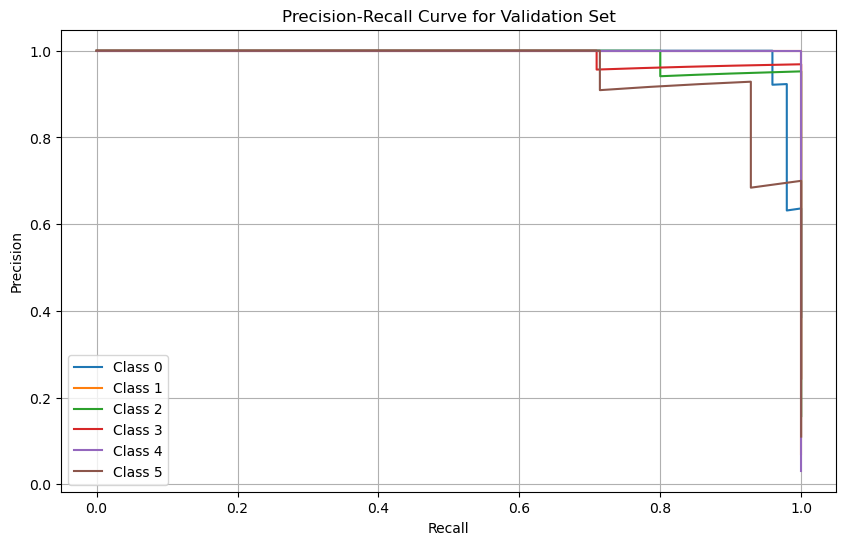

🔍 Evaluating Testing Set: 100%|█████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.78s/it]


Testing Set Accuracy: 95.31%
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        42
           1       1.00      0.93      0.97        15
           2       0.94      0.89      0.92        19
           3       0.96      0.96      0.96        25
           4       1.00      1.00      1.00        13
           5       1.00      0.86      0.92        14

    accuracy                           0.95       128
   macro avg       0.97      0.94      0.95       128
weighted avg       0.96      0.95      0.95       128

[[42  0  0  0  0  0]
 [ 0 14  0  1  0  0]
 [ 2  0 17  0  0  0]
 [ 1  0  0 24  0  0]
 [ 0  0  0  0 13  0]
 [ 1  0  1  0  0 12]]


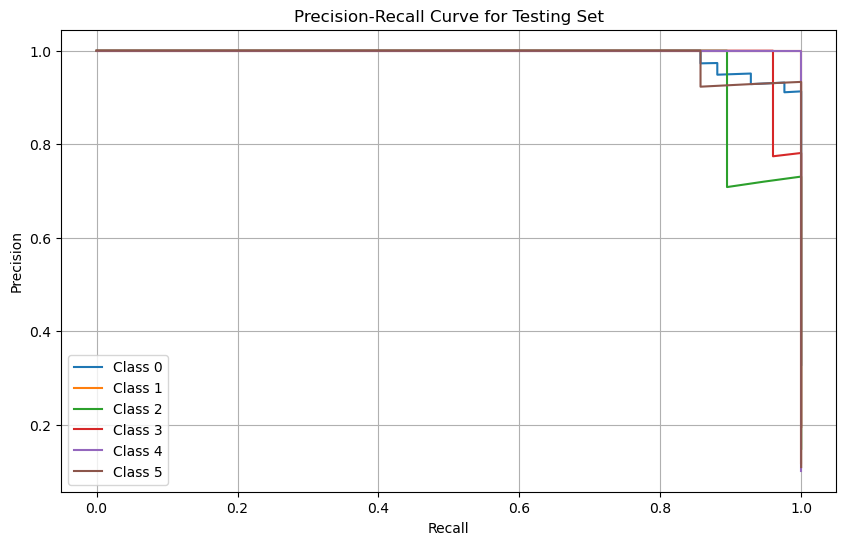

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [22]:
train_inception(train_loader, val_loader, num_classes=6, num_epochs=20, lr=0.0001)